<a href="https://colab.research.google.com/github/gylam/siads696-sprsum2024-team05/blob/main/4_supervised_multiclass_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import requirements

import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

##### Load in data

In [ ]:
# loading data- preprocessed text
df_cleaned = pd.read_pickle(r'../data/m2_dataset_clean.pkl')
print(df_cleaned.shape)

(181469, 18)


In [ ]:

# Create a new dataframe with reduced columns
# df1 = df[['combined_text', 'theme_name']].copy()
df1 = df_cleaned[['combined_text', 'cleaned_text', 'theme_name', 'report_id']].copy()
df1.shape

(181469, 4)

In [ ]:
#filter df1 to retain only top10 themes
top_10_themes = df1['theme_name'].value_counts()[:10].reset_index()['theme_name']
df1 = df1[df1['theme_name'].isin(top_10_themes)]
df1.shape

(161874, 4)

In [ ]:
#classes are imbalanced
df1['theme_name'].value_counts()

theme_name
Protection and Human Rights       62596
Health                            36493
Peacekeeping and Peacebuilding    11404
Recovery and Reconstruction        9524
Food and Nutrition                 8766
Shelter and Non-Food Items         8387
Contributions                      7628
Agriculture                        6581
Water Sanitation Hygiene           5306
Disaster Management                5189
Name: count, dtype: int64

##### Balance the dataset

In [ ]:
#Balance the classes
theme_list= list(df1['theme_name'].unique())

def balance_dataset(df, documents_per_label):
  df_balanced = pd.DataFrame(columns = list(df.columns))

  for theme in theme_list:
    try:
      df_theme = df[df['theme_name'] == theme].sample(documents_per_label)
    except:
      df_theme = df[df['theme_name'] == theme]
    df_balanced = pd.concat([df_balanced, df_theme])
  return df_balanced

df2= balance_dataset(df1, 2000)
df2.shape

(20000, 4)

In [ ]:
#classes are now balanced
df2['theme_name'].value_counts()

theme_name
Agriculture                       2000
Disaster Management               2000
Peacekeeping and Peacebuilding    2000
Protection and Human Rights       2000
Food and Nutrition                2000
Contributions                     2000
Shelter and Non-Food Items        2000
Recovery and Reconstruction       2000
Health                            2000
Water Sanitation Hygiene          2000
Name: count, dtype: int64

In [ ]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['theme_name'].factorize()[0]
category_id_df = df2[['theme_name', 'category_id']].drop_duplicates()
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'theme_name']].values)
# New dataframe
df2.head(3)

,combined_text,cleaned_text,theme_name,report_id,category_id
974,Cattle ranching project transforms Chilonga Th...,ranch project transforms traditional cattle ra...,Agriculture,722366,0
166,Inner Mongolia suffers from heavy drought Edit...,suffers heavy drought percent north suffer per...,Agriculture,2674979,0
1111,Angola: Uruguay offers cattle breeding support...,offer cattle breed support visit president cou...,Agriculture,136480,0


##### visualizations for class imbalance

Text(0.5, 0, 'Number of reports')

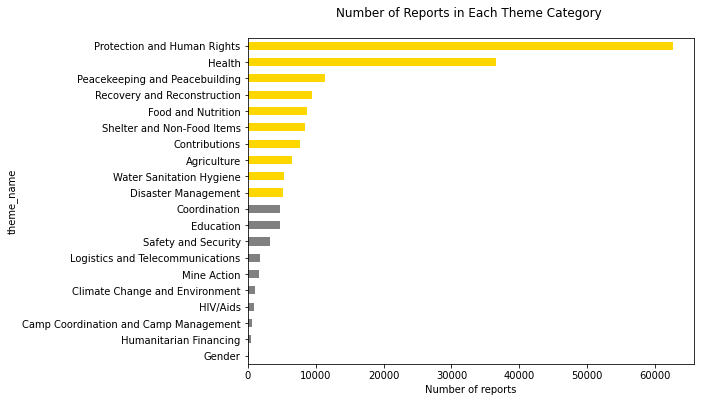

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey', 'grey',
          'gold','gold','gold','gold','gold','gold','gold','gold','gold', 'gold']
graph = df_cleaned.groupby('theme_name').combined_text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'Number of Reports in Each Theme Category \n')
plt.xlabel('Number of reports', fontsize = 10)

Text(0.5, 0, 'Number of reports')

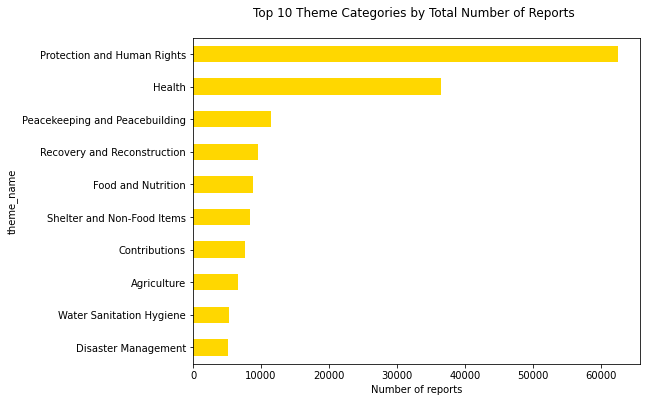

In [ ]:
#top 10 themes class count distribution
fig = plt.figure(figsize=(8,6))
colors = ['gold','gold','gold','gold','gold','gold','gold','gold','gold', 'gold']
df1.groupby('theme_name').combined_text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'Top 10 Theme Categories by Total Number of Reports \n')
plt.xlabel('Number of reports', fontsize = 10)

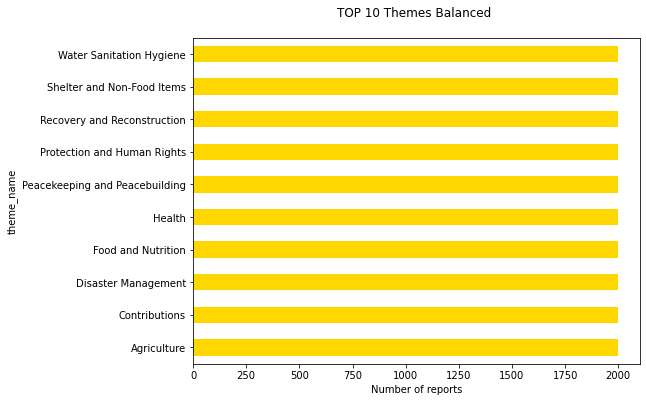

In [ ]:
#top 10 themes blanaced
fig = plt.figure(figsize=(8,6))
colors = ['gold','gold','gold','gold','gold','gold','gold','gold','gold', 'gold']
df2.groupby('theme_name').combined_text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'TOP 10 Themes Balanced \n')
plt.xlabel('Number of reports', fontsize = 10);

##### vectorization of text

In [ ]:
text_column = 'combined_text' #combined_text, cleaned_text

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,ngram_range=(1, 2), stop_words='english', max_features=5000)
# (sublinear_tf = True, min_df = 5, ngram_range = (1,3), max_df=0.75, use_idf=True, stop_words='english', norm = 'l2', max_features=None)
# (sublinear_tf=True, min_df=5,ngram_range=(1, 2), stop_words='english', max_features=5000)
# We transform each report into a vector
features = tfidf.fit_transform(df2[text_column]).toarray()
labels = df2.category_id
print("Each of the %d report is represented by %d features. \nFeatures are the TF-IDF scores of unigrams and bigrams" %(features.shape))

Each of the 20000 report is represented by 5000 features. 
Features are the TF-IDF scores of unigrams and bigrams


##### Finding terms most correlated with each class

In [ ]:
# Finding the three most correlated terms with each of the theme categories
N = 3
for theme_name, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("Theme: %s:" %(theme_name))
  print("Unigrams with Most Weight are: %s" %(', '.join(unigrams[-N:])))
  print("Biigrams with Most Weight are: %s" %(', '.join(bigrams[-N:])))
  print(f"\n")

Theme: Agriculture:
Unigrams with Most Weight are: agriculture, agricultural, farmers
Biigrams with Most Weight are: breeding areas, control operations, desert locust


Theme: Contributions:
Unigrams with Most Weight are: donation, million, contribution
Biigrams with Most Weight are: foreign affairs, million humanitarian, humanitarian aid


Theme: Disaster Management:
Unigrams with Most Weight are: preparedness, reduction, disaster
Biigrams with Most Weight are: risk management, risk reduction, disaster risk


Theme: Food and Nutrition:
Unigrams with Most Weight are: hunger, food, wfp
Biigrams with Most Weight are: food programme, wfp org, food assistance


Theme: Health:
Unigrams with Most Weight are: patients, health, cases
Biigrams with Most Weight are: ministry health, confirmed cases, cases reported


Theme: Peacekeeping and Peacebuilding:
Unigrams with Most Weight are: political, elections, peace
Biigrams with Most Weight are: peace process, secretary general, security council




##### Train Test Split

In [ ]:
X = df2[text_column] # Collection of documents
y = df2['theme_name'] # labels
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state = 0)

##### 5 Fold Cross Validation of 4 different Classifiers

In [ ]:
models = [
    RandomForestClassifier(random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

In [ ]:
#cross validation results
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.85165,0.003534
LogisticRegression,0.85465,0.005738
MultinomialNB,0.79645,0.004403
RandomForestClassifier,0.81165,0.003732


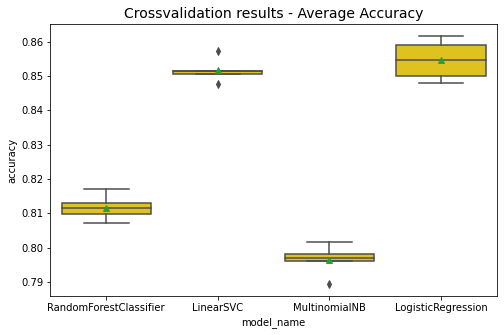

In [ ]:
#visualize results of 5 fold crossvalidation with 4 classifier models
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='gold',
            showmeans=True)
plt.title("Crossvalidation results - Average Accuracy", size=14);

##### Best Model- Training

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(X,y, df2.index, test_size=0.2,random_state=1)
xtrain_tfidf =  tfidf.transform(X_train)
xtest_tfidf =  tfidf.transform(X_test)

model = LogisticRegression(C=1, fit_intercept=False, tol=0.01,random_state=0)
#(C=1, fit_intercept=False, tol=0.01,random_state=0)
#(C=10, dual=True, fit_intercept=False, solver='liblinear', max_iter = 100, random_state=0)
model.fit(xtrain_tfidf, y_train)
y_pred = model.predict(xtest_tfidf)

In [ ]:
# Classification report
print(f'Classification Report - Logistic Regression\n')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['theme_name'].unique()))

Classification Report - Logistic Regression

                                precision    recall  f1-score   support

                   Agriculture       0.90      0.87      0.88       416
           Disaster Management       0.84      0.82      0.83       414
Peacekeeping and Peacebuilding       0.90      0.91      0.90       405
   Protection and Human Rights       0.86      0.86      0.86       422
            Food and Nutrition       0.93      0.91      0.92       361
                 Contributions       0.89      0.88      0.89       422
    Shelter and Non-Food Items       0.82      0.87      0.85       380
   Recovery and Reconstruction       0.75      0.75      0.75       384
                        Health       0.80      0.81      0.81       388
      Water Sanitation Hygiene       0.90      0.91      0.90       408

                      accuracy                           0.86      4000
                     macro avg       0.86      0.86      0.86      4000
                 

In [ ]:
#compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test), index = np.unique(y_test))
cm

,Agriculture,Contributions,Disaster Management,Food and Nutrition,Health,Peacekeeping and Peacebuilding,Protection and Human Rights,Recovery and Reconstruction,Shelter and Non-Food Items,Water Sanitation Hygiene
Agriculture,360,2,4,21,4,0,3,5,7,10
Contributions,3,341,4,16,4,7,8,16,13,2
Disaster Management,7,6,367,2,2,1,2,11,5,2
Food and Nutrition,17,11,4,361,2,0,4,5,16,2
Health,0,5,2,5,330,1,1,5,4,8
Peacekeeping and Peacebuilding,2,6,1,0,0,372,28,12,1,0
Protection and Human Rights,3,4,1,3,3,19,330,10,6,1
Recovery and Reconstruction,6,14,12,6,5,16,17,287,15,6
Shelter and Non-Food Items,0,15,8,5,2,1,4,27,316,10
Water Sanitation Hygiene,2,4,4,1,3,0,4,7,13,370


Text(0.5, 1.0, 'Logisitic Regression Results- Confusion Matrix')

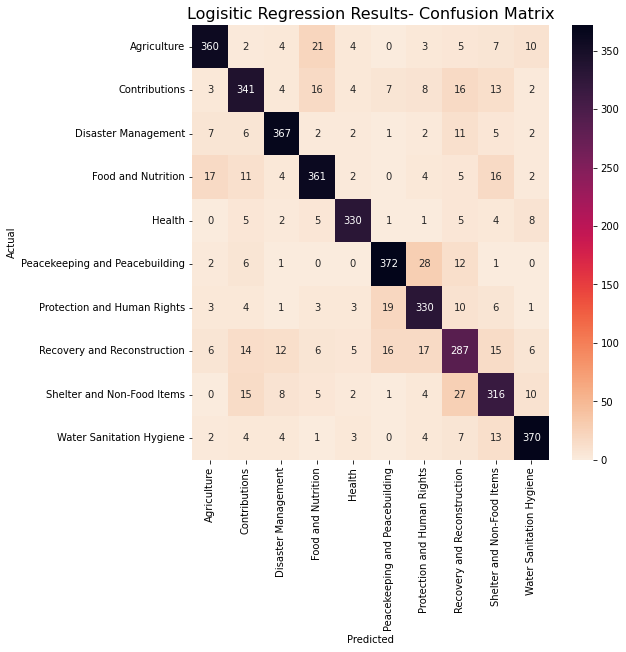

In [ ]:
#visualize confusion matrix
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="rocket_r", fmt='d')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Logisitic Regression Results- Confusion Matrix", size=16)

##### Top features

In [ ]:
idx=0
for theme in list(model.classes_):
    print(theme)
    _ = pd.DataFrame({"coef": model.coef_[idx], "coef_abs": np.abs(model.coef_[idx]), "word": tfidf.get_feature_names_out()})
    print(_.sort_values("coef_abs", ascending = False).head(5))
    idx+=1

Agriculture
          coef  coef_abs          word
1767  6.870288  6.870288       farmers
372   5.920685  5.920685   agriculture
369   5.802327  5.802327  agricultural
1761  3.988885  3.988885           fao
1139  3.858688  3.858688         crops
Contributions
          coef  coef_abs          word
2881  6.396463  6.396463       million
66    4.000405  4.000405          2001
1053  3.750555  3.750555  contribution
378   3.531192  3.531192           aid
1     3.436731  3.436731           000
Disaster Management
          coef  coef_abs          word
1352  5.311990  5.311990      disaster
3923  3.985908  3.985908          risk
1362  3.937506  3.937506     disasters
3450  3.921169  3.921169  preparedness
2769  3.703025  3.703025    management
Food and Nutrition
           coef   coef_abs          word
1860  13.416383  13.416383          food
4903   5.973776   5.973776           wfp
3112   4.269121   4.269121     nutrition
3907   4.139448   4.139448          rice
2765   4.137037   4.137037  

##### Create df for Failure Analysis

In [ ]:
#identify misclassified documents
misclassified = list(np.where(y_pred != y_test))
print(f"Of the {len(y_test)} reports tetsed, the number of reports misclassified are {len(misclassified[0])}")


Of the 4000 reports tetsed, the number of reports misclassified are 578


In [ ]:
#create df_misclassified for failure analysis
df_pred = pd.DataFrame(columns = ['combined_text', 'actual_theme', 'predicted_theme'] )
df_pred['combined_text'] = X_test
df_pred['actual_theme'] = y_test
df_pred['predicted_theme'] = y_pred
df_pred

,combined_text,actual_theme,predicted_theme
104,USAID sends more food for the people of Afghan...,Contributions,Food and Nutrition
107,Update on medical assistance to injured Libyan...,Health,Health
203,"An end of a chapter, a start of another Over t...",Disaster Management,Peacekeeping and Peacebuilding
1134,Vulnerable Women Expand Economic Opportunities...,Water Sanitation Hygiene,Recovery and Reconstruction
934,Solar Power Offers Affordable Solutions for Ke...,Agriculture,Agriculture
...,...,...,...
1088,Sri Lanka: Protect civilians in 'final' attack...,Protection and Human Rights,Protection and Human Rights
1113,Statement by UNDP Administrator Helen Clark on...,Recovery and Reconstruction,Recovery and Reconstruction
225,"Back-to-back cyclones cross Yemen, with people...",Disaster Management,Shelter and Non-Food Items
730,Red Cross continues to meet emergency water ne...,Water Sanitation Hygiene,Water Sanitation Hygiene


In [ ]:
df_misclassified = df_pred.merge(df_cleaned[['report_id', 'combined_text']], how = 'left', on='combined_text')
df_misclassified

,combined_text,actual_theme,predicted_theme,report_id
0,USAID sends more food for the people of Afghan...,Contributions,Food and Nutrition,90521
1,Update on medical assistance to injured Libyan...,Health,Health,451554
2,"An end of a chapter, a start of another Over t...",Disaster Management,Peacekeeping and Peacebuilding,2046444
3,Vulnerable Women Expand Economic Opportunities...,Water Sanitation Hygiene,Recovery and Reconstruction,1861304
4,Solar Power Offers Affordable Solutions for Ke...,Agriculture,Agriculture,1467956
...,...,...,...,...
3995,Sri Lanka: Protect civilians in 'final' attack...,Protection and Human Rights,Protection and Human Rights,305456
3996,Statement by UNDP Administrator Helen Clark on...,Recovery and Reconstruction,Recovery and Reconstruction,681509
3997,"Back-to-back cyclones cross Yemen, with people...",Disaster Management,Shelter and Non-Food Items,1254201
3998,Red Cross continues to meet emergency water ne...,Water Sanitation Hygiene,Water Sanitation Hygiene,190575


In [ ]:
df_misclassified.to_csv('..\data\RW_Themes_LR_Misclassified.csv')

##### Grid Search- Logistic Regression

In [ ]:
#Grid Search
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.01, 0.1, 1, 10],
              'solver': ['lbfgs', 'liblinear', 'newton-cg'],
              'fit_intercept': [True, False],
               'dual': ['auto', True, False],
               'max_iter':[100, 500, 1000 ],
              'class_weight': [None, 'balanced'],
              'tol': [0.0001, 0.001, 0.01],
              'penalty': ['l1', 'l2'],
                }

grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(xtrain_tfidf, y_train)


Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
[CV 1/5] END C=0.01, class_weight=None, dual=auto, fit_intercept=True, max_iter=100, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.3s
[CV 2/5] END C=0.01, class_weight=None, dual=auto, fit_intercept=True, max_iter=100, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, class_weight=None, dual=auto, fit_intercept=True, max_iter=100, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, class_weight=None, dual=auto, fit_intercept=True, max_iter=100, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, class_weight=None, dual=auto, fit_intercept=True, max_iter=100, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, class_weight=None, dual=auto, fit_intercept=True, max_iter=100, penalty=l1, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END C=0.

C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.850 total time=   4.8s
[CV 2/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.856 total time=   4.5s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.853 total time=   5.0s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.858 total time=   4.6s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.846 total time=   5.1s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.850 total time=   5.4s
[CV 2/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.856 total time=   5.6s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.853 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.858 total time=   5.3s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.846 total time=   5.7s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.850 total time=   5.8s
[CV 2/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.856 total time=   5.1s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.853 total time=   4.9s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.858 total time=   5.0s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.846 total time=   5.0s
[CV 1/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.848 total time=   3.2s
[CV 2/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.855 total time=   3.2s
[CV 3/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.852 total time=   3.1s
[CV 4/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.855 total time=   3.1s
[CV 5/5] END C=1, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.847 total time=   3.3s
[CV 1/5] END C=1, class_weight=None, dual=False, fit_intercept=T

C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.850 total time=   6.7s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.855 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.852 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.858 total time=   6.1s
[CV 5/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.845 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.850 total time=   6.6s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.855 total time=   6.0s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.852 total time=   5.9s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.858 total time=   6.1s
[CV 5/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.845 total time=   6.1s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.850 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.855 total time=   6.5s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.852 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.858 total time=   6.2s
[CV 5/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.845 total time=   5.8s
[CV 1/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.847 total time=   3.8s
[CV 2/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.855 total time=   3.8s
[CV 3/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.852 total time=   3.5s
[CV 4/5] END C=1, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.856 total time=   3.6s
[CV 5/5] END C=1, class_weight=balanced, dual=

C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.848 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.852 total time=   6.3s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.846 total time=   6.1s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.858 total time=   6.0s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.843 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.848 total time=   5.9s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.852 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.846 total time=   5.8s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.858 total time=   6.3s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.843 total time=   6.3s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.848 total time=   6.1s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.852 total time=   5.9s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.846 total time=   5.9s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.858 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.843 total time=   6.4s
[CV 1/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.848 total time=   5.8s
[CV 2/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.855 total time=   5.1s
[CV 3/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.846 total time=   5.3s
[CV 4/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.862 total time=   5.4s
[CV 5/5] END C=10, class_weight=None, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.846 total time=   5.2s
[CV 1/5] END C=10, class_weight=None, dual=False, fit_inte

C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.849 total time=   6.6s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.851 total time=   6.0s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.846 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.859 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.0001;, score=0.843 total time=   6.1s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.849 total time=   6.5s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.851 total time=   6.1s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.846 total time=   6.1s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.859 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.001;, score=0.843 total time=   6.1s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.849 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.851 total time=   6.4s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.846 total time=   6.1s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.859 total time=   6.2s


C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=lbfgs, tol=0.01;, score=0.843 total time=   6.2s
[CV 1/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.847 total time=   5.2s
[CV 2/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.856 total time=   5.1s
[CV 3/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.847 total time=   5.1s
[CV 4/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.862 total time=   5.9s
[CV 5/5] END C=10, class_weight=balanced, dual=False, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001;, score=0.845 total time=   6.2s
[CV 1/5] END C=10, class_weight=ba

C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9360 fits failed out of a total of 12960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4320 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hinam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\loc

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'],
                         'dual': ['auto', True, False],
                         'fit_intercept': [True, False],
                         'max_iter': [100, 500, 1000], 'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg'],
                         'tol': [0.0001, 0.001, 0.01]},
             verbose=3)

In [ ]:


# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.01}
LogisticRegression(C=1, fit_intercept=False, tol=0.01)


##### TFIDF gridsearch

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(C=1, fit_intercept=False, tol=0.01)),
])

# uncomment parameter to explore further but it will increase computational time
parameters = {
    # 'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
    # 'tfidf__sublinear_tf': (True, False),
    # 'tfidf__min_df': (5, 10, 15),
    # 'tfidf__max_features': (None, 100,500,1000,5000),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # unigrams or bigrams or trigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
}

grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
grid_search.fit(X_train, y_train)

print("Best parameters set:")
print (grid_search.best_estimator_.steps)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
